In [3]:
import torch
import torchaudio
import numpy as np
import pandas as pd
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model, Wav2Vec2Config

2025-02-24 04:33:41.941161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 04:33:41.948830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740351821.957907    7220 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740351821.960575    7220 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 04:33:41.970631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model, Wav2Vec2Config

class Wav2VecClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(Wav2VecClassifier, self).__init__()
        
        # Load the pre-trained Wav2Vec model
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        
        # Freeze the feature extractor layers (optional)
        for param in self.wav2vec.feature_extractor.parameters():
            param.requires_grad = False
            
        # Get the output dimension of wav2vec
        hidden_size = self.wav2vec.config.hidden_size  # typically 768
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Get wav2vec features
        outputs = self.wav2vec(x)
        hidden_states = outputs.last_hidden_state
        
        # Pool the output (take mean of all time steps)
        pooled_output = torch.mean(hidden_states, dim=1)
        
        # Classify
        logits = self.classifier(pooled_output)
        return logits

# Let's test the model with random data
def test_model():
    # Create model instance
    model = Wav2VecClassifier(num_classes=3)
    model.eval()
    
    # Create random input tensor
    # Wav2Vec expects input shape: [batch_size, sequence_length]
    # Typical audio sampling rate is 16kHz, let's create 1 second of audio
    batch_size = 2
    sequence_length = 16000  # 1 second of audio at 16kHz
    random_audio = torch.randn(batch_size, sequence_length)
    
    # Forward pass
    with torch.no_grad():
        output = model(random_audio)
    
    print("Input shape:", random_audio.shape)
    print("Output shape:", output.shape)
    print("Output (logits):", output)

# Run the test
test_model()

/home/ayushraina/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Input shape: torch.Size([2, 16000])
Output shape: torch.Size([2, 3])
Output (logits): tensor([[-0.0357,  0.0148,  0.0854],
        [-0.0675, -0.0265,  0.0939]])


In [12]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset
from transformers import Wav2Vec2FeatureExtractor
import numpy as np

class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
        self.sample_rate = 16000  # Wav2Vec2 requires 16kHz
        
        # Create class mapping
        self.class_mapping = {
            'Cry': 0,
            'NotScreaming': 1,
            'Screaming': 2
        }
        
        # Create file list and labels
        self.files = []
        self.labels = []
        
        # Walk through all directories
        for class_name in self.class_mapping.keys():
            class_dir = os.path.join(root_dir, class_name)
            class_label = self.class_mapping[class_name]
            
            for filename in os.listdir(class_dir):
                if filename.endswith('.wav'):
                    self.files.append(os.path.join(class_dir, filename))
                    self.labels.append(class_label)
    
    def __len__(self):
        return len(self.files)
    
    def preprocess_audio(self, audio_path):
        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Resample if necessary
        if sample_rate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            waveform = resampler(waveform)
        
        # Convert to numpy array and squeeze
        waveform = waveform.squeeze().numpy()
        
        # Normalize audio
        waveform = waveform / np.max(np.abs(waveform))
        
        return waveform
    
    def __getitem__(self, idx):

        audio_path = self.files[idx]
        label = self.labels[idx]
        # Preprocess audio

        waveform = self.preprocess_audio(audio_path)
        # Convert to tensor

        waveform_tensor = torch.FloatTensor(waveform)
        return waveform_tensor, label


    def preprocess_audio(self, audio_path):

        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)

        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if necessary
        if sample_rate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            waveform = resampler(waveform)

        # Convert to numpy array and squeeze
        waveform = waveform.squeeze().numpy()

        # Normalize audio
        waveform = waveform / np.max(np.abs(waveform)) if np.max(np.abs(waveform)) > 0 else waveform

        return waveform

# Let's test the dataset
def test_dataset():
    # Initialize dataset
    dataset = AudioDataset(root_dir='Datasets')
    
    # Print dataset info
    print(f"Total samples: {len(dataset)}")
    print("\nClass distribution:")
    labels = [dataset.labels[i] for i in range(len(dataset))]
    unique, counts = np.unique(labels, return_counts=True)
    for class_name, count in zip(dataset.class_mapping.keys(), counts):
        print(f"{class_name}: {count}")
    
    # Test loading one sample
    input_values, label = dataset[0]
    print(f"\nSample input shape: {input_values.shape}")
    print(f"Sample label: {label}")

    return dataset

# Run the test
if __name__ == "__main__":
    dataset = test_dataset()

Total samples: 3950

Class distribution:
Cry: 457
NotScreaming: 2631
Screaming: 862

Sample input shape: torch.Size([112000])
Sample label: 0


In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import numpy as np

def collate_fn(batch):

    """
    Custom collate function to handle variable length audio inputs
    """

    # Separate inputs and labels
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Get max length in the batch
    max_length = max([input_tensor.shape[0] for input_tensor in inputs])


    # Pad inputs to max length
    padded_inputs = []

    for input_tensor in inputs:
        if input_tensor.shape[0] < max_length:
            # Pad with zeros
            padding = torch.zeros(max_length - input_tensor.shape[0])
            padded_input = torch.cat([input_tensor, padding])

        else:
            padded_input = input_tensor
        padded_inputs.append(padded_input)

    # Stack all inputs and labels
    inputs_tensor = torch.stack(padded_inputs)
    labels_tensor = torch.tensor(labels)
    
    return inputs_tensor, labels_tensor

# Modify the create_data_loaders function to include the collate_fn
def create_data_loaders(dataset, batch_size=32, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Creates train, validation, and test DataLoaders from a dataset
    """
    # Generate indices for the entire dataset
    indices = list(range(len(dataset)))
    
    # First split: separate train and temp (val + test)
    train_indices, temp_indices = train_test_split(
        indices,
        train_size=train_size,
        random_state=random_state,
        stratify=[dataset.labels[i] for i in indices]
    )

    # Second split: separate val and test from temp
    val_indices, test_indices = train_test_split(
        temp_indices,
        train_size=val_size/(val_size + test_size),
        random_state=random_state,
        stratify=[dataset.labels[i] for i in temp_indices]
    )

    # Create Subset objects
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)
    
    # Create DataLoaders with custom collate_fn
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader

def get_labels_from_loader(loader, dataset):
    """
    Helper function to get labels from a loader
    """
    labels = []
    for idx in loader.dataset.indices:
        labels.append(dataset.labels[idx])
    return labels

def print_split_info(train_loader, val_loader, test_loader, dataset):
    """
    Prints information about the dataset splits
    """
    print("\nDataset split information:")
    print(f"Total samples: {len(dataset)}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Testing samples: {len(test_loader.dataset)}")
    
    # Get class distribution
    train_labels = get_labels_from_loader(train_loader, dataset)
    val_labels = get_labels_from_loader(val_loader, dataset)
    test_labels = get_labels_from_loader(test_loader, dataset)
    
    print("\nClass distribution:")
    print("Classes:", list(dataset.class_mapping.keys()))
    print("Training set:", np.bincount(train_labels))
    print("Validation set:", np.bincount(val_labels))
    print("Testing set:", np.bincount(test_labels))

def prepare_data():
    # Create dataset
    dataset = AudioDataset(root_dir='Datasets')
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        dataset,
        batch_size=32,
        train_size=0.7,
        val_size=0.15,
        test_size=0.15
    )
    
    # Print split information
    print_split_info(train_loader, val_loader, test_loader, dataset)
    
    return train_loader, val_loader, test_loader

# Test the data preparation
if __name__ == "__main__":
    train_loader, val_loader, test_loader = prepare_data()
    
    # Test a batch
    for batch_inputs, batch_labels in train_loader:
        print("\nSample batch information:")
        print(f"Input shape: {batch_inputs.shape}")
        print(f"Labels shape: {batch_labels.shape}")
        print(f"Sample labels: {batch_labels[:5]}")
        break


Dataset split information:
Total samples: 3950
Training samples: 2765
Validation samples: 592
Testing samples: 593

Class distribution:
Classes: ['Cry', 'NotScreaming', 'Screaming']
Training set: [ 320 1842  603]
Validation set: [ 69 394 129]
Testing set: [ 68 395 130]

Sample batch information:
Input shape: torch.Size([32, 160000])
Labels shape: torch.Size([32])
Sample labels: tensor([2, 1, 1, 0, 1])


/home/ug/Ayush/AudioClassification/myenv/lib64/python3.11/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/home/ug/Ayush/AudioClassification/myenv/lib64/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Dataset split information:
Total samples: 3950
Training samples: 2765
Validation samples: 592
Testing samples: 593

Class distribution:
Classes: ['Cry', 'NotScreaming', 'Screaming']
Training set: [ 320 1842  603]
Validation set: [ 69 394 129]
Testing set: [ 68 395 130]
Starting training...


Epoch 1/20 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.53it/s, loss=0.5393, acc=86.82%]



Epoch 1/20:
Train Loss: 0.5356, Train Acc: 78.55%
Val Loss: 0.3363, Val Acc: 86.82%
------------------------------------------------------------


Epoch 2/20 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.59it/s, loss=0.4454, acc=89.19%]



Epoch 2/20:
Train Loss: 0.4128, Train Acc: 83.11%
Val Loss: 0.3103, Val Acc: 89.19%
------------------------------------------------------------


Epoch 3/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  4.94it/s, loss=0.5318, acc=87.84%]



Epoch 3/20:
Train Loss: 0.2827, Train Acc: 89.98%
Val Loss: 0.2892, Val Acc: 87.84%
------------------------------------------------------------


Epoch 4/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  4.78it/s, loss=0.3929, acc=89.36%]



Epoch 4/20:
Train Loss: 0.3117, Train Acc: 89.37%
Val Loss: 0.2877, Val Acc: 89.36%
------------------------------------------------------------


Epoch 5/20 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.67it/s, loss=0.4311, acc=86.32%]



Epoch 5/20:
Train Loss: 0.2584, Train Acc: 90.60%
Val Loss: 0.3357, Val Acc: 86.32%
------------------------------------------------------------


Epoch 6/20 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, loss=0.4845, acc=91.05%]



Epoch 6/20:
Train Loss: 0.2318, Train Acc: 91.75%
Val Loss: 0.2533, Val Acc: 91.05%
------------------------------------------------------------


Epoch 7/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.24it/s, loss=0.3819, acc=85.64%]



Epoch 7/20:
Train Loss: 0.1850, Train Acc: 93.24%
Val Loss: 0.3412, Val Acc: 85.64%
------------------------------------------------------------


Epoch 8/20 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.71it/s, loss=0.5494, acc=90.71%]



Epoch 8/20:
Train Loss: 0.1633, Train Acc: 94.29%
Val Loss: 0.2926, Val Acc: 90.71%
------------------------------------------------------------


Epoch 9/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  4.99it/s, loss=0.6675, acc=88.68%]



Epoch 9/20:
Train Loss: 0.1489, Train Acc: 95.12%
Val Loss: 0.3198, Val Acc: 88.68%
------------------------------------------------------------


Epoch 10/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.08it/s, loss=0.6413, acc=90.54%]



Epoch 10/20:
Train Loss: 0.1249, Train Acc: 96.24%
Val Loss: 0.3266, Val Acc: 90.54%
------------------------------------------------------------


Epoch 11/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.20it/s, loss=0.7101, acc=90.03%]



Epoch 11/20:
Train Loss: 0.0849, Train Acc: 97.79%
Val Loss: 0.3547, Val Acc: 90.03%
------------------------------------------------------------


Epoch 12/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.17it/s, loss=1.0055, acc=89.36%]



Epoch 12/20:
Train Loss: 0.0902, Train Acc: 97.72%
Val Loss: 0.4256, Val Acc: 89.36%
------------------------------------------------------------


Epoch 13/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  4.92it/s, loss=0.6322, acc=90.54%]



Epoch 13/20:
Train Loss: 0.0774, Train Acc: 98.12%
Val Loss: 0.3519, Val Acc: 90.54%
------------------------------------------------------------


Epoch 14/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s, loss=0.5898, acc=89.36%]



Epoch 14/20:
Train Loss: 0.0759, Train Acc: 98.16%
Val Loss: 0.3397, Val Acc: 89.36%
------------------------------------------------------------


Epoch 15/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.03it/s, loss=0.7185, acc=90.03%]



Epoch 15/20:
Train Loss: 0.0570, Train Acc: 98.84%
Val Loss: 0.3875, Val Acc: 90.03%
------------------------------------------------------------


Epoch 16/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.11it/s, loss=0.6712, acc=90.54%]



Epoch 16/20:
Train Loss: 0.0529, Train Acc: 98.95%
Val Loss: 0.3832, Val Acc: 90.54%
------------------------------------------------------------


Epoch 17/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.06it/s, loss=0.6857, acc=90.88%]



Epoch 17/20:
Train Loss: 0.0498, Train Acc: 99.06%
Val Loss: 0.4013, Val Acc: 90.88%
------------------------------------------------------------


Epoch 18/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.14it/s, loss=0.7801, acc=90.37%]



Epoch 18/20:
Train Loss: 0.0499, Train Acc: 99.02%
Val Loss: 0.4163, Val Acc: 90.37%
------------------------------------------------------------


Epoch 19/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.05it/s, loss=0.7138, acc=89.02%]



Epoch 19/20:
Train Loss: 0.0450, Train Acc: 99.10%
Val Loss: 0.4436, Val Acc: 89.02%
------------------------------------------------------------


Epoch 20/20 [Val]: 100%|██████████| 19/19 [00:03<00:00,  5.08it/s, loss=0.7803, acc=90.20%]



Epoch 20/20:
Train Loss: 0.0441, Train Acc: 99.17%
Val Loss: 0.4265, Val Acc: 90.20%
------------------------------------------------------------


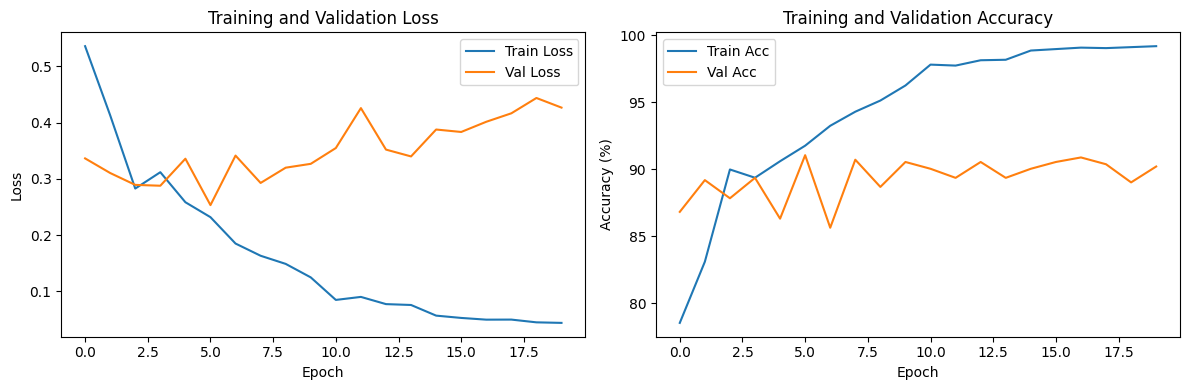

In [28]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

class TrainingManager:
    def __init__(self, model, train_loader, val_loader, device, 
                 learning_rate=1e-4, num_epochs=20, checkpoint_dir='checkpoints'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_epochs = num_epochs
        self.checkpoint_dir = checkpoint_dir
        
        # Create checkpoint directory if it doesn't exist
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        
        # Initialize criterion and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', patience=2, factor=0.5, verbose=True)
        
        # Initialize tracking variables
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')
        
    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Create progress bar
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} [Train]')
        
        for inputs, labels in pbar:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            # Zero the parameter gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            self.optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                            'acc': f'{100 * correct / total:.2f}%'})
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc
    
    def validate(self, epoch):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} [Val]')
            
            for inputs, labels in pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                                'acc': f'{100 * correct / total:.2f}%'})
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc
    
    def save_checkpoint(self, epoch, val_loss):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
        }
        torch.save(checkpoint, f'{self.checkpoint_dir}/checkpoint_epoch_{epoch}.pt')
        
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            torch.save(checkpoint, f'{self.checkpoint_dir}/best_model.pt')
    
    def train(self):
        print("Starting training...")
        
        for epoch in range(self.num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(epoch)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            
            # Validation phase
            val_loss, val_acc = self.validate(epoch)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            
            # Save checkpoint
            self.save_checkpoint(epoch, val_loss)
            
            # Print epoch summary
            print(f'\nEpoch {epoch+1}/{self.num_epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print('-' * 60)
        
        self.plot_training_history()
        
    def plot_training_history(self):
        plt.figure(figsize=(12, 4))
        
        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Acc')
        plt.plot(self.val_accuracies, label='Val Acc')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

# Usage example:
if __name__ == "__main__":
    # Assuming we have our model and data loaders ready
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Wav2VecClassifier(num_classes=3)
    
    # Get your data loaders from the previous step
    train_loader, val_loader, test_loader = prepare_data()
    
    # Initialize trainer
    trainer = TrainingManager(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=1e-4,
        num_epochs=20
    )
    
    # Start training
    trainer.train()

In [30]:
import pandas as pd
import csv
from datetime import datetime

def save_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, filename=None):
    """
    Save training metrics to a CSV file
    """
    # If filename not provided, create one with timestamp
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'training_metrics_{timestamp}.csv'
    
    # Create a dictionary of metrics
    metrics_dict = {
        'epoch': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }
    
    # Convert to DataFrame
    df = pd.DataFrame(metrics_dict)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"\nTraining metrics saved to: {filename}")
    
    # Also display final metrics
    print("\nFinal Metrics:")
    print(f"Best Training Accuracy: {max(train_accuracies):.2f}%")
    print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")

# If you have the variables from your previous training:
# Assuming these are your variables from the previous training
train_losses = trainer.train_losses
val_losses = trainer.val_losses
train_accuracies = trainer.train_accuracies
val_accuracies = trainer.val_accuracies

# Save the metrics
save_training_metrics(
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
    filename='wav2vec_training_metrics.csv'
)


Training metrics saved to: wav2vec_training_metrics.csv

Final Metrics:
Best Training Accuracy: 99.17%
Best Validation Accuracy: 91.05%
Final Training Loss: 0.0441
Final Validation Loss: 0.4265


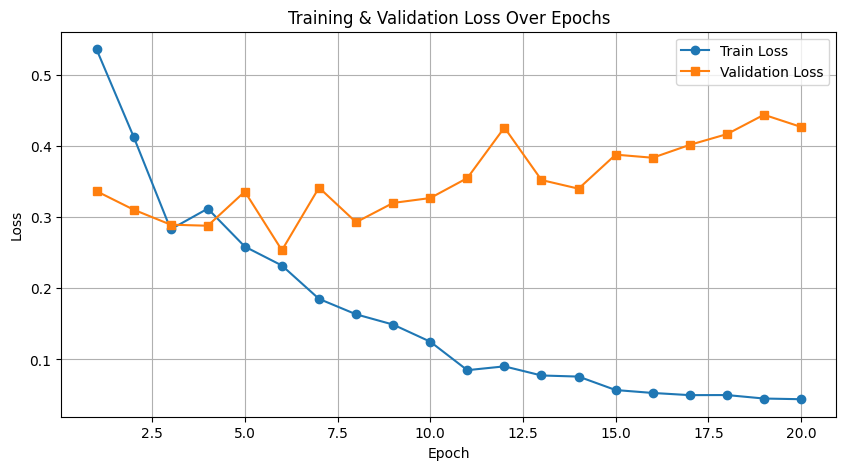

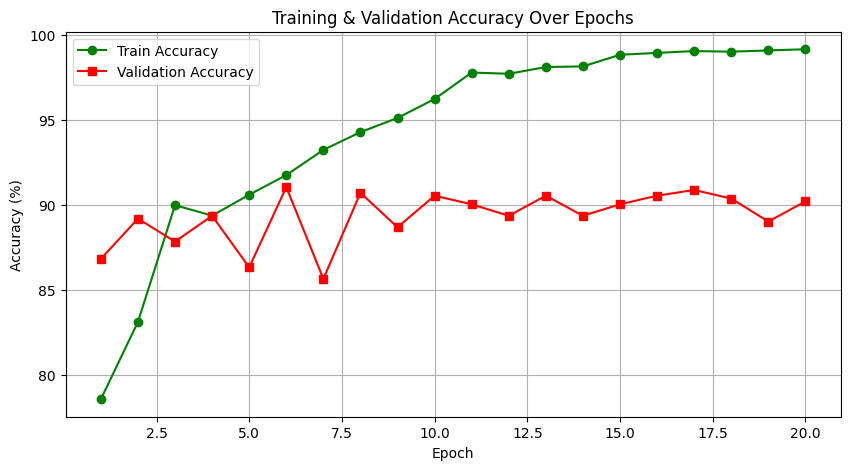

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
csv_file = "wav2vec_training_metrics.csv"
df = pd.read_csv(csv_file)

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss", marker="o")
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracies
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train_accuracy"], label="Train Accuracy", marker="o", color="g")
plt.plot(df["epoch"], df["val_accuracy"], label="Validation Accuracy", marker="s", color="r")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()


In [32]:
# Save the model
torch.save(model.state_dict(), 'wav2vec_model.pth')
print("Model saved to wav2vec_model.pth")   

Model saved to wav2vec_model.pth


In [8]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model, Wav2Vec2Config

In [9]:
# Load the model
model = Wav2VecClassifier(num_classes=3)
model.load_state_dict(torch.load('wav2vec_model.pth'))
model.eval()

Wav2VecClassifier(
  (wav2vec): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encode

In [10]:
# Test the model on test set in CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate the model on the test set
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluation')
        
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'acc': f'{100 * correct / total:.2f}%'})
    
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model
accuracy = evaluate_model(model, test_loader, device)
print(f"\nTest Accuracy: {accuracy:.2f}%")
    

NameError: name 'test_loader' is not defined

Predicting: 100%|██████████| 19/19 [00:03<00:00,  4.90it/s]


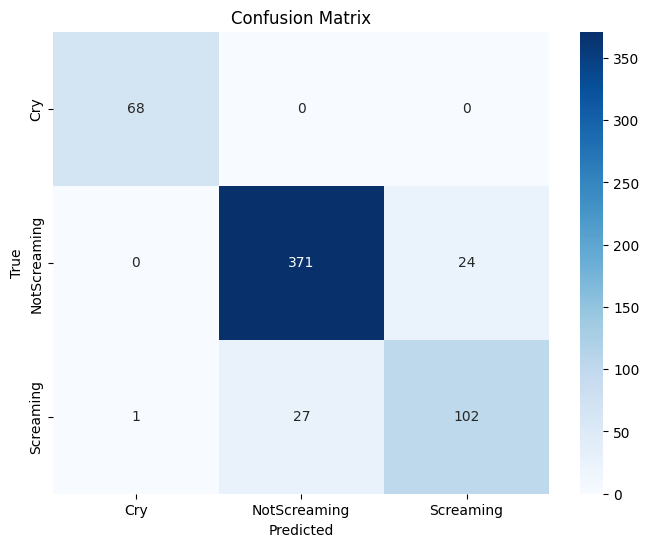

In [17]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, device):
    
    # Get predictions
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Predicting')
        
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=dataset.class_mapping.keys(), 
                yticklabels=dataset.class_mapping.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
# Plot confusion matrix
plot_confusion_matrix(model, test_loader, device)



Predicting for ROC AUC: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s]


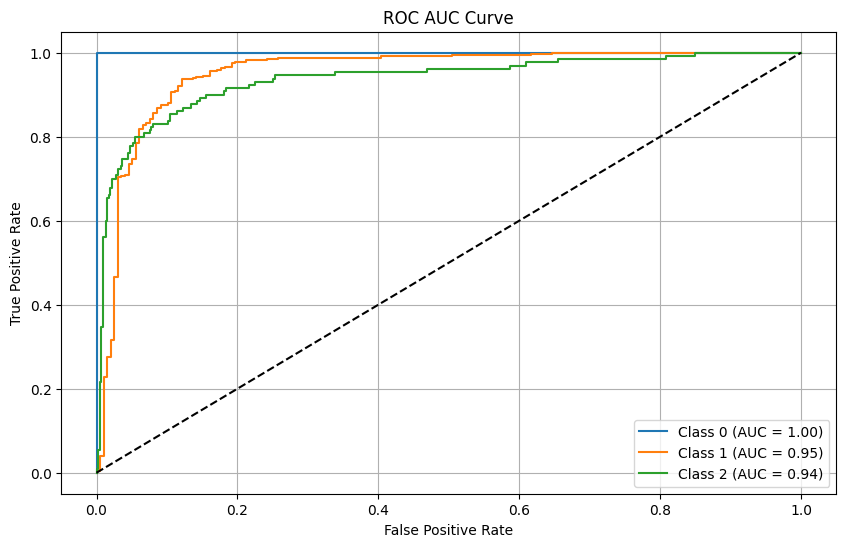

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_auc(model, test_loader, device, num_classes):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Predicting for ROC AUC")
        
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # One-hot encode labels for multi-class ROC AUC
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    # Plot ROC AUC Curve
    plt.figure(figsize=(10, 6))
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC AUC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function
num_classes = 3  # Cry, NotScreaming, Screaming
plot_roc_auc(model, test_loader, device, num_classes)


Predicting for PR Curve: 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


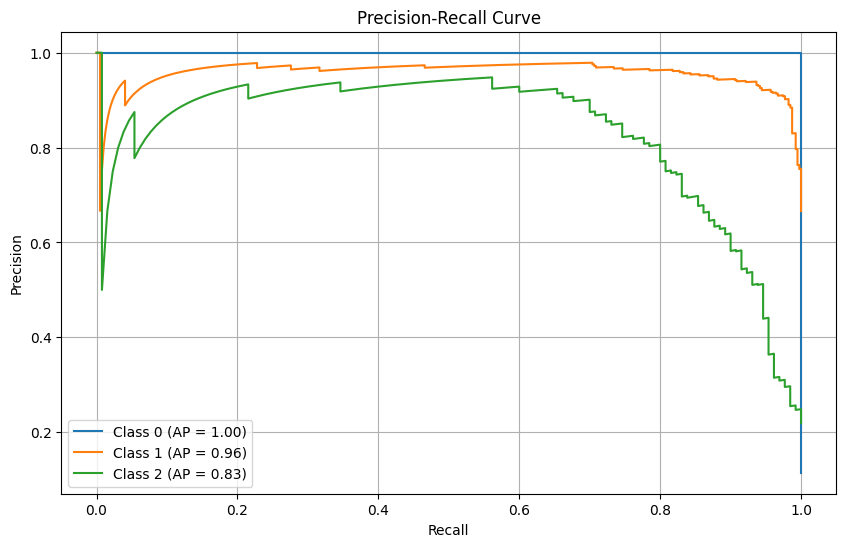

In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_pr_curve(model, test_loader, device, num_classes):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Predicting for PR Curve")
        
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Get class probabilities
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # One-hot encode labels for multi-class PR curve
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    # Plot Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_scores[:, i])
        plt.plot(recall, precision, label=f"Class {i} (AP = {ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function
num_classes = 3  # Cry, NotScreaming, Screaming
plot_pr_curve(model, test_loader, device, num_classes)


In [13]:
# Test the model on random .wav file
def test_model_on_audio(model, audio_path, feature_extractor, device):
    # Preprocess audio
    waveform = dataset.preprocess_audio(audio_path)
    input_values = torch.FloatTensor(waveform).unsqueeze(0).to(device)
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(input_values)
    
    # Get predicted class
    _, predicted = torch.max(outputs.data, 1)
    
    # Get class name
    class_mapping = {v: k for k, v in dataset.class_mapping.items()}
    predicted_class = class_mapping[predicted.item()]
    
    return predicted_class

# Test the model on a random audio file
audio_path = "Datasets/Cry/0c8f14a9-6999-485b-97a2-913c1cbf099c-1430760379259-1.7-m-26-hu.wav"
predicted_class = test_model_on_audio(model, audio_path, dataset.feature_extractor, device)
print(f"Predicted Class: {predicted_class}")

Predicted Class: Cry
